# Сбор данных и анализ групп пользователей социальной сети ВКонтакте

## Для анализа мы решили взять группы с тематикой гоночной серии "Формула 1":
- [Формула 1 / F1 / Чемпионат 2022](https://vk.com/formula1.championat)
- [Гран-При Формула 1 | GP Formula One](https://vk.com/grand_prixf1_ru)

В дальнейшем датасеты с постами из __Формула 1 / F1 / Чемпионат 2022__ будет называться `formula_df`, из __Гран-При Формула 1 | GP Formula One__ - `gp_df`  
Списки участников групп будут называться `formula_members` и `gp_members` соответственно

## Загрузка библиотек, предобработка данных

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import re
from collections import Counter
from IPython.display import Image

In [2]:
with open('posts_of_groups.pickle', 'rb') as handle:
    posts_data = pickle.load(handle)

In [3]:
ids_of_posts = []
post_text = []
post_date = []
for i in range(min(2000, len(posts_data['formula1.championat']))):
    current_post = posts_data['formula1.championat'][i]
    ids_of_posts.append(current_post['id'])
    post_text.append(current_post['text'])
    post_date.append(current_post['date'])

formula_df = pd.DataFrame.from_dict({
    'post_id': ids_of_posts,
    'text': post_text,
    'date_post': post_date
})

In [4]:
ids_of_posts = []
post_text = []
post_date = []
for i in range(min(2000, len(posts_data['grand_prixf1_ru']))):
    current_post = posts_data['grand_prixf1_ru'][i]
    ids_of_posts.append(current_post['id'])
    post_text.append(current_post['text'])
    post_date.append(current_post['date'])

gp_df = pd.DataFrame.from_dict({
    'post_id': ids_of_posts,
    'text': post_text,
    'date_post': post_date
})

In [5]:
formula_df

,post_id,text,date_post
0,665,Где смотреть Формулу 1❓❓❓❓❓ 😡😈😭😱😨\n \n1️⃣ Перв...,1647592505
1,701,Прогноз на сезон Формулы 1 2022 года. Выводы п...,1648033832
2,700,Формула-1. Обзор Гран-при Бахрейна. Ferrari св...,1648029131
3,699,Эпизод 107 - Красный Дельфин. Гран-При Бахрейн...,1647958911
4,698,"Сделал ""обзор"" на новый болид F1 Mercedes!?!\n...",1647958852
...,...,...,...
608,11,«Макларен» из F1 засветил по ТВ шпаргалку для ...,1617883318
609,10,29 нарушений Хэмилтона и ни одного штрафа?! Чт...,1617882985
610,9,"Болельщики F1 дают советы, как сделать гонки к...",1617882678
611,8,"5 пилотов F1, которых могут уволить в 2021 😡\n...",1617882289


In [6]:
gp_df

,post_id,text,date_post
0,3887,Сегодня свой 26-ой день рождения отмечает Алек...,1648024390
1,3884,Рубрика история гоночных серий:\nИстория чемпи...,1647886866
2,3882,6 Трасс формулы 1: \n1) Аделаида (временная тр...,1647886613
3,3880,2 погибших пилотов формулы 1 :\n1) Роланд Ратц...,1647886392
4,3879,Сегодня день рождения 3х кратного чемпиона мир...,1647880299
...,...,...,...
1995,1080,,1554561489
1996,1079,,1554537060
1997,1078,,1554526002
1998,1077,,1554353521


In [7]:
formula_df['date_post'] = pd.to_datetime(formula_df['date_post'], unit='s')

In [8]:
gp_df['date_post'] = pd.to_datetime(gp_df['date_post'], unit='s')

In [9]:
with open('members_of_groups.pickle', 'rb') as handle:
    members_data = pickle.load(handle)
    
formula_members = members_data['formula1.championat']
gp_members = members_data['grand_prixf1_ru']

## 2. Есть ли пользователи, относящиеся к обоим сообществам?

In [10]:
common_members_ids = []

for i, member_id in enumerate(formula_members):
    if member_id in gp_members:
        common_members_ids.append(member_id)

output = f'В группе "Формула 1 / F1 / Чемпионат 2022" {len(formula_members)} участников\n' + \
         f'В группе "Гран-При Формула 1 | GP Formula One" {len(gp_members)} участников\n\n' + \
         f'В обеих группах одновременно состоят {len(common_members_ids)} человек!'
print(output)

В группе "Формула 1 / F1 / Чемпионат 2022" 1360 участников
В группе "Гран-При Формула 1 | GP Formula One" 1826 участников

В обеих группах одновременно состоят 49 человек!


## 3. Если используются хэштеги, то составьте топ хэштегов по встречаемости для каждой группы, визуализируйте полученные результаты. Сравните списки на предмет пересечений

In [38]:
def count_hastags(df_column):
    hashtags = [re.findall('#\w+', i) for i in df_column]
    list_of_hashtags = [item for sublist in hashtags for item in sublist]
    hashtags_usage = dict(Counter(list_of_hashtags))
    return {k: v for k, v in sorted(hashtags_usage.items(), key=lambda item: item[1], reverse=True)}

In [39]:
formula_hashtags_usage = count_hastags(formula_df.text.to_list())

In [40]:
gp_hashtags_usage = count_hastags(gp_df.text.to_list())

In [53]:
fig = go.Figure(go.Bar(
            x=list(formula_hashtags_usage.values())[:20][::-1],
            y=list(formula_hashtags_usage.keys())[:20][::-1],
            orientation='h'))

fig.update_yaxes(title="Хэштег")
fig.update_xaxes(title="Количество использований")
fig.update_layout(title="20 популярных хэштегов в постах сообщества <b>Формула 1 / F1 / Чемпионат 2022</b>",
                  title_font={'size': 20})
fig.update_traces(hovertemplate="%{x} использований хэштега %{y}<extra></extra>")

fig.show()

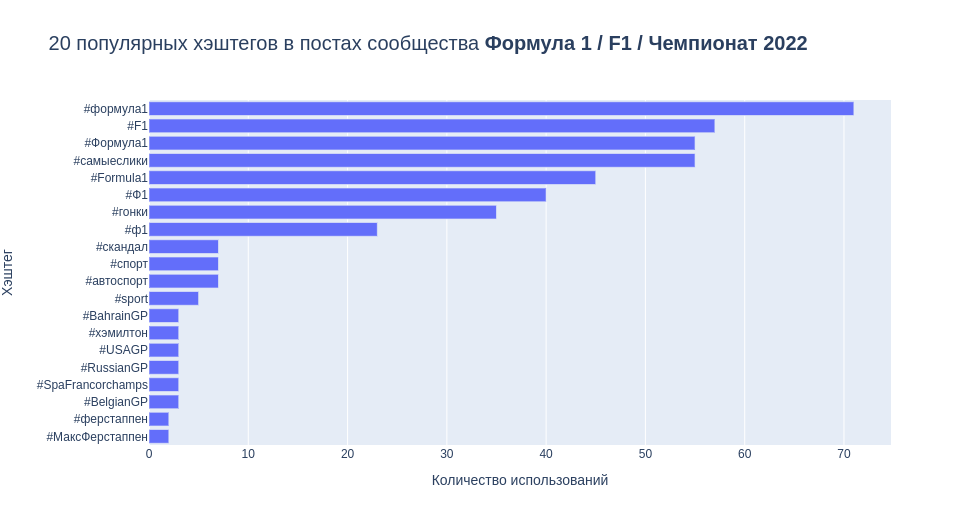

In [60]:
Image(filename='images/hash_formula.png') 

In [55]:
fig = go.Figure(go.Bar(
            x=list(gp_hashtags_usage.values())[:20][::-1],
            y=list(gp_hashtags_usage.keys())[:20][::-1],
            orientation='h'))

fig.update_yaxes(title="Хэштег")
fig.update_xaxes(title="Количество использований")
fig.update_layout(title="20 популярных хэштегов в постах сообщества <b>Гран-При Формула 1 | GP Formula One</b>",
                  title_font={'size': 20})
fig.update_traces(hovertemplate="%{x} использований хэштега %{y}<extra></extra>")

fig.show()

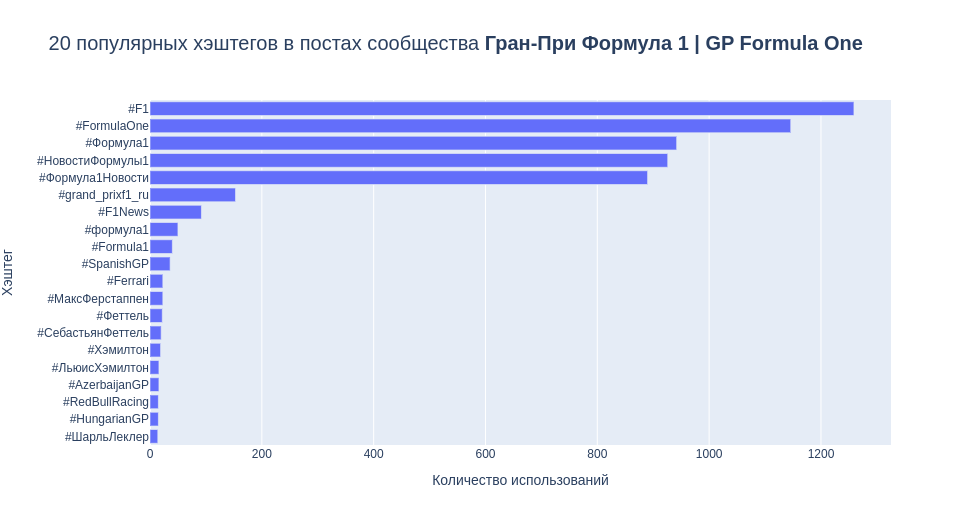

In [61]:
Image(filename='images/hash_gp.png') 

In [57]:
fig = go.Figure()

fig.add_trace(go.Bar(
            x=list(formula_hashtags_usage.values())[:10][::-1],
            y=list(formula_hashtags_usage.keys())[:10][::-1],
            orientation='h', name="Формула 1 / F1 /<br>Чемпионат 2022"))

fig.add_trace(go.Bar(
            x=list(gp_hashtags_usage.values())[:10][::-1],
            y=list(gp_hashtags_usage.keys())[:10][::-1],
            orientation='h', name="Гран-При Формула 1 |<br>GP Formula One"))

fig.update_yaxes(title="Хэштег")
fig.update_xaxes(title="Количество использований")
fig.update_layout(barmode='stack',
                  title="Хэштеги в обоих сообществах</b>",
                  title_font={'size': 20})
fig.update_traces(hovertemplate="%{x} использований хэштега %{y}<extra></extra>")

fig.show()

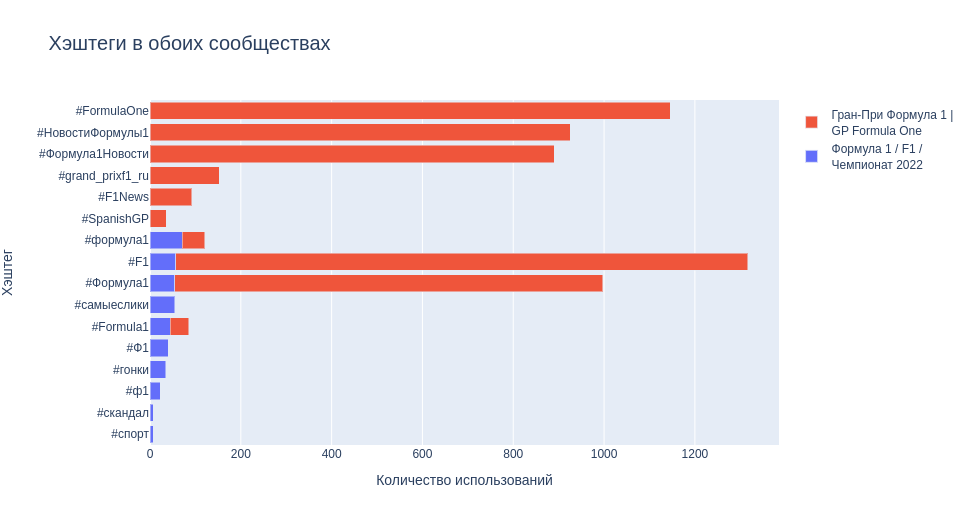

In [62]:
Image(filename='images/hash_both.png') 

#### Среди хештегов чаще всего используются именование гоночной серии, хэштег новостей, упоминается крупный ютьюб-канал "Самые слики" и гонщики: Леклер, Ферстаппен и т.д.

## 4. Посчитайте количество постов за каждый час суток для обоих сообществ, визуализируйте результаты. В какое время суток наиболее активны участники социальных групп? Совпадают ли часы с наибольшей активностью для обоих сообществ?

In [11]:
formula_df['date_post'].dt.hour.value_counts().sort_index()

4       3
5       5
6      24
7      25
8      27
9      21
10     28
11     43
12     45
13     39
14     25
15      9
16     19
17     24
18     63
19    149
20     61
21      3
Name: date_post, dtype: int64

#### В часы 0 - 3 и 22 - 23 не было постов в этом сообществе

In [12]:
formula_df_post_hours = [0, 0, 0, 0] + list(formula_df['date_post'].dt.hour.value_counts().sort_index().values) + [0, 0]

In [13]:
gp_df['date_post'].dt.hour.value_counts().sort_index()

0       6
1       6
2      13
3      24
4     117
5     100
6      94
7      78
8      75
9     113
10    105
11     85
12    103
13    118
14    133
15    146
16    163
17    116
18    120
19    112
20     92
21     57
22     11
23     13
Name: date_post, dtype: int64

In [58]:
fig = go.Figure()

fig.add_trace(go.Line(name="Формула 1 / F1 /<br>Чемпионат 2022", 
                      x=list(range(24)),
                      y=formula_df_post_hours))
fig.add_trace(go.Line(name="Гран-При Формула 1 |<br>GP Formula One", 
                      x=list(range(24)),
                      y=gp_df['date_post'].dt.hour.value_counts().sort_index()))


fig.update_layout(title='Распределение количества постов групп в течение дня')
fig.update_traces(hoverinfo='x+y', hovertemplate="%{x} часов: %{y} постов")
fig.update_yaxes(title="Количество постов")
fig.update_xaxes(title="Час")
fig.update_layout(title_font={'size': 28})
fig.show()

/home/alexanderlakiza/.virtualenvs/itmo_sma/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/home/alexanderlakiza/.virtualenvs/itmo_sma/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




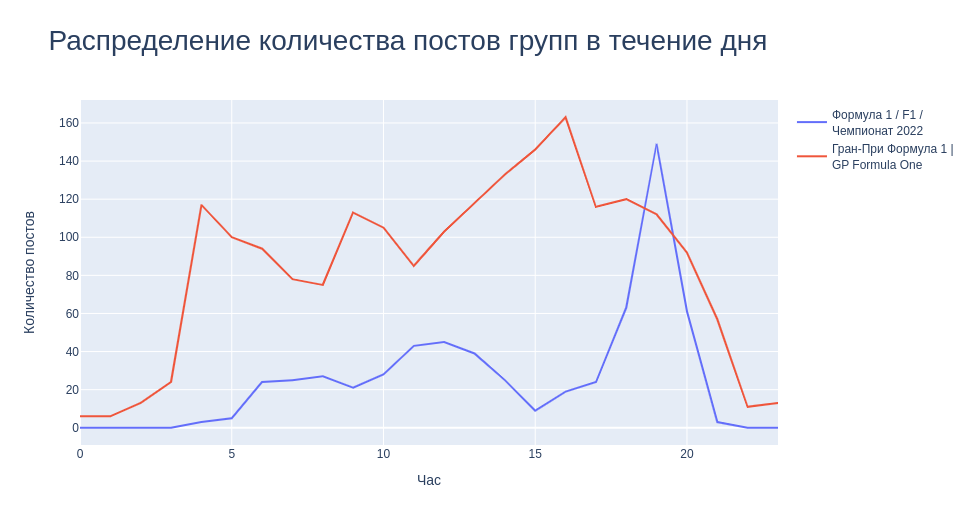

In [63]:
Image(filename='images/posts_day.png') 

#### Так как в одной группе меньше постов, чем 2000, стоит нормализовать эти данные и построить новые графики

In [59]:
fig = go.Figure()

gp_df_hours_norm = [round(100*i/len(gp_df['date_post']), 1) for i in gp_df['date_post'].dt.hour.value_counts().sort_index().values]
formula_df_hours_norm = [round(100*i/len(formula_df['date_post']) , 1) for i in formula_df_post_hours]

fig.add_trace(go.Line(name="Формула 1 / F1 /<br>Чемпионат 2022", 
                      x=list(range(24)),
                      y=formula_df_hours_norm))
fig.add_trace(go.Line(name="Гран-При Формула 1 |<br>GP Formula One", 
                      x=list(range(24)),
                      y=gp_df_hours_norm))


fig.update_layout(title='Распределение постов групп в течение дня')
fig.update_traces(hoverinfo='x+y', hovertemplate="%{x} часов: %{y}% постов")
fig.update_yaxes(title="Процент постов")
fig.update_xaxes(title="Час")
fig.update_layout(title_font={'size': 28})
fig.show()

/home/alexanderlakiza/.virtualenvs/itmo_sma/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




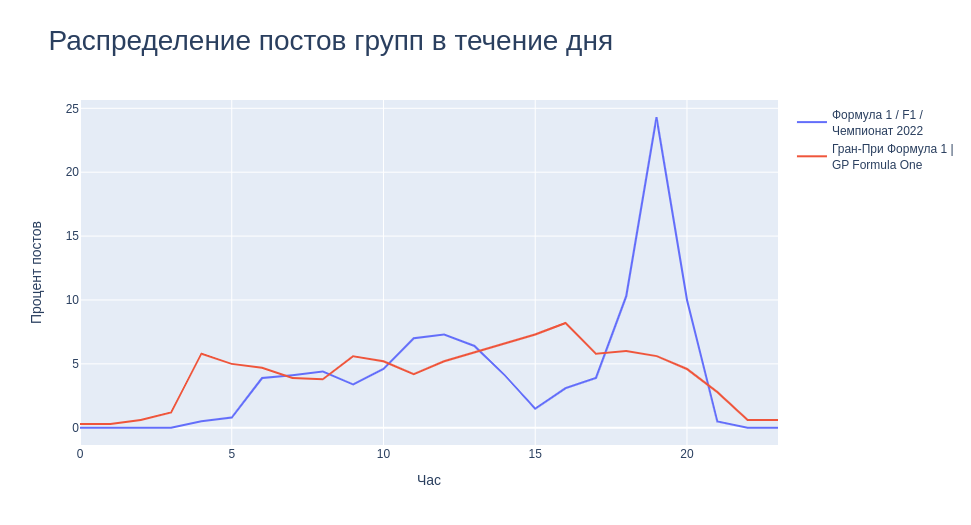

In [64]:
Image(filename='images/posts_day_norm.png') 

## 5. Постройте социальные графы для обоих сообществ.

## 6. Сколько узлов получилось в каждом из графов? А сколько рёбер?

## 7. При помощи кластеризации выделите сообщества внутри обоих графов. Сколько сообществ получилось выделить в исследуемых графах?